#### NOTE

This is still very much a work in progress. The code is just a sketch and the explanation are not sufficient. I hope is understandable enough.

In [3]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import matplotlib.pyplot as plt
import quimb as qu
import quimb.tensor as qtn
from quimb.experimental.merabuilder import MERA
import torch
import torch.nn as nn

ModuleNotFoundError: No module named 'numpy'

In [ ]:
Psi = qtn.MPS_rand_state(L=10, bond_dim=2)

## Tree-TensorNetwork as generator

Following https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.155131

### Definition

<img src="./images/img1.png" alt="Example Image" width="700" style="display: block; margin-left: auto; margin-right: auto;" />

As illustrated in Fig. 1(b), each circle represents
a tensor; each edge of the circle represents an individual
index of the tensor. The first tensor is a matrix connecting the
second and third tensors, while the remaining tensors are all
three-order tensors with three indices. The index between two
tensors is called a virtual bond, which would be contracted
hereafter. The left and right indices of the tensors in the
bottom of the TTN are respectively connected to two pixels
of the input image and hence are called physical bonds.

The bond dimension in a tensor network refers to the dimension of the shared index (or bond) connecting two tensors. 
Higher bond dimensions allow more complex entanglement between subsystems to be represented. In quantum many-body systems, the bond dimension represents the number of states used to approximate the entanglement structure.

Since bond dimension represents on how many indices we are summing, it is related to how well we can represent states with our tensor network.
In the context of Matrix Product States (MPS), the bond dimension directly corresponds to the Schmidt rank of the state for each bipartition. If the bond dimension is h , the MPS can capture states with a maximum Schmidt rank of h.

$|\psi\rangle=\sum_{i=1}^D \lambda_i\left|u_i\right\rangle_A \otimes\left|v_i\right\rangle_B$, where D is the Schmidt rank, the number of non-zero $\lambda$, which quantifies the enganglement between the two subsystems A and B (for D=1 the state is separable).

In [18]:
def build_ttn(number_physical_indexes, bond_dimension, number_layers):
    #
    # this function builds a tree tensor network with the specified number of physical indexes, bond dimension and number of layers
    # the tree tensor network is composed of number_layers layers of rank-3 random tensors halving the number at each layer
    # the function returns the tensor network, a matrix of tensors composing it and the list of lenghts of each layer
    # root is considered a layer and the function does not check if the number of physical indexes is compatible with the number of layers
    #
    ttn_shape = [int(number_physical_indexes / (2 ** (i + 1))) for i in range(number_layers)]
    
    index = [[] for _ in range(number_layers)]
    index[0] = [f'ph{i}' for i in range(number_physical_indexes)]
    for i in range(1, number_layers):
        index[i] = [f'b{i-1}{j}' for j in range(ttn_shape[i-1])]
    
    tensor = [[] for _ in range(number_layers)]
    tensor[0] = [qtn.rand_tensor([bond_dimension] * 3, inds=[index[0][2 * i], index[0][2 * i + 1], index[1][i]], tags=f't0{i}') for i in range(ttn_shape[0])]
    for i in range(1, number_layers - 1):
        tensor[i] = [qtn.rand_tensor([bond_dimension] * 3, inds=[index[i][2 * j], index[i][2 * j + 1], index[i + 1][j]], tags=f't{i}{j}') for j in range(ttn_shape[i])]
    tensor[number_layers - 1] = [qtn.rand_tensor([bond_dimension] * 2, inds=[index[number_layers - 1][2 * k], index[number_layers - 1][2 * k + 1]], tags=f't{number_layers - 1}{k}') for k in range(ttn_shape[number_layers - 1])]
    
    return qtn.TensorNetwork(tensor), tensor, ttn_shape

In [19]:
number_physical_indexes = 64
bond_dimension = 2
number_layers = 6

tensor_network, tensor, ttn_shape = build_ttn(number_physical_indexes, bond_dimension, number_layers)

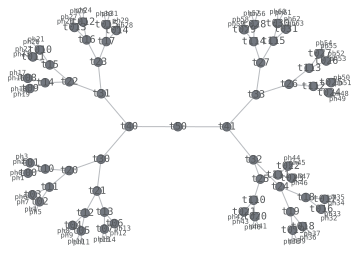

In [20]:
tensor_network.draw(show_inds=True,show_tags=True)

### Canonizing

We can now procede in canonicalization procedure for each layer of the TNN, taking the root tensor as central tensor. In this procedure we have to keep an eye on indexes, since the QR decomposition, the first block of indices is assigned to Q and the second one (in our case, the only "upper" one) is assigned to R, to be contracted with the next layer. The algorithm creates a new set of indexes beetween the first and second layer, that we have to rename.

<div style="text-align: center;">
    <img src="./images/img2.png" alt="Example Image" width="1500" style="display: block; margin-left: auto; margin-right: auto;"/>
    <p>The arrow on U means it's unitary</p>
</div>

Quimb has a default algorith to canonize bonds

In [21]:
for i in range(ttn_shape[1]):
    qtn.tensor_canonize_bond(tensor[0][2*i], tensor[1][i])
    qtn.tensor_canonize_bond(tensor[0][2*i+1], tensor[1][i])
for i in range(ttn_shape[2]):
    qtn.tensor_canonize_bond(tensor[1][2*i], tensor[2][i])
    qtn.tensor_canonize_bond(tensor[1][2*i+1], tensor[2][i])

### Perfect sampling algorithm

https://tensornetwork.org/mps/algorithms/sampling/ here the example is aplied to MPS but can be generalized to other TNs, including TTN

https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.155131 chapter II-F

https://journals.aps.org/prb/pdf/10.1103/PhysRevB.85.165146


We can assume our probability distribution to be:
$$p\left(s_1, s_2, s_3, \ldots, s_N\right)=\left|T^{s_1 s_2 s_3 \cdots s_N}\right|^2$$
First we need to make sure it is normalized to one.
$$\sum_{\{s\}}\left|T^{s_1 s_2 s_3 \cdots s_N}\right|^2=1 \text {, or }$$

In [228]:
tensor_network = tensor_network / tensor_network.norm()

The principle underlying the MPS sampling algorithm below is the “chain rule” of probability

$$p\left(s_1, s_2, s_3, \ldots, s_N\right)=p\left(s_1\right) p\left(s_2 \mid s_1\right) p\left(s_3 \mid s_1 s_2\right) \cdots p\left(s_N \mid s_1 s_2 s_3 \cdots s_{N-1})\right.$$

computing each factor on the right we will get a single sample from the full distribution.

Let' start with $P(s_1)$
$$p\left(s_1\right)=\sum_{s_2, s_3, \ldots, s_N} p\left(s_1, s_2, \ldots, s_N\right)=\sum_{s_2, s_3, \ldots, s_N} T^{s_1 s_2 \cdots s_N} \bar{T}^{s_1 s_2 \ldots s_N}$$

<div style="text-align: center;">
    <img src="./images/img3.png" alt="Sampling Algorithm Image" width="600" style="display: block; margin-left: auto; margin-right: auto;" />
</div>

In [229]:
step_tensor_network = tensor_network.H.reindex({'ph0':'ph0*'})&tensor_network
step_tensor_network.draw(color=['t00'],show_tags=True)

In [230]:
reduced_tensor_network = step_tensor_network.contract(all)
reduced_tensor_network.draw(color=['t00'],show_inds=True,show_tags=True)

The result is a matrix (“reduced density matrix”), but here we will only need its diagonal elements, ph0=ph0*. 
Contracting with the basis elements (0,1) and (1,0) we get $p(s_0)$ and $p(s_1)$. It must hold $p(s_0)+p(s_1)=1$. Drawing a value from this probability distribution is equivalent to extract a value in $r\in[0,1]$ and if $r<p_1$ then $\hat{s_1}=(0,1)$ and viceversa.

In [231]:
v0 = qtn.Tensor(data=[0,1], inds=['ph0'])
v1 = qtn.Tensor(data=[1,0], inds=['ph0'])
ps0 = v0@reduced_tensor_network@v0.reindex({'ph0':'ph0*'})
ps1 = v1@reduced_tensor_network@v1.reindex({'ph0':'ph0*'})
print('ps0: ',ps0)
print('ps1: ',ps1)
print('normalization check: ',ps0+ps1)
r = np.random.uniform(0, 1)
print('random number: ', r)
s_hat = [[]]
if r < ps0:
    s_hat[0] = v0.data
else:
    s_hat[0] = v1.data
print('s_hat vector: ', s_hat[0])

Now we can contract the tensor network with s0 and repeat the process for $s_2$, to compute $p(s_2|\hat s_1)$, and so on to $p(\hat s_N,....,\hat s_1)$

In [232]:
v = qtn.Tensor(data=s_hat[0], inds=['ph0'])
step_tensor_network = step_tensor_network @ v.reindex({'ph0':'ph0*'}) @ v

I will write it down again in one algorithm for convenience

In [20]:
# def perfect_sampling_ttn(ttn,number_indexes):
#     s_hat = np.zeros([number_indexes,2])
#     probability = np.zeros(number_indexes)

#     # cycle 0: the ttn is connected to the conjugate, except for the ph0 index, we obtain a matrix, multiplied by the basis vectors
#     # gives me the probability of extracting the first element. We extract the first element
#     # cycle 1: the vector extracted in the previous cycle is connected to the ph0 index of the ttn. The procedure repeats identically

#     for i in range(number_indexes):
#         step_tensor_network = tensor_network

#         for j in range(i): 
#             # for each cycle connect a tensor to an index (in sequence from ph0 to ph14) up to the index before 
#             # the one I want to sample
#             v = qtn.Tensor(data=s_hat[j], inds=[f'ph{j}'], tags=[f'v{int(s_hat[j][0])}'])
#             step_tensor_network = step_tensor_network & v
#             step_tensor_network = step_tensor_network / np.sqrt(probability[j])

#         # take the complex conjugate of the new network with the same indices as the first one except for the one I want to sample
#         step_tensor_network_full = step_tensor_network.H.reindex({f'ph{i}':f'ph{i}*'}) & step_tensor_network

#         # contraction of the network, I get the probability matrix of extracting the new element
#         reduced_tensor_network = step_tensor_network_full.contract(all)

#         # calculate the probability of extracting the two elements
#         v0 = qtn.Tensor(data=[0,1], inds=[f'ph{i}'])
#         v1 = qtn.Tensor(data=[1,0], inds=[f'ph{i}'])
#         ps0 = v0 @ reduced_tensor_network @ v0.reindex({f'ph{i}':f'ph{i}*'})
#         ps1 = v1 @ reduced_tensor_network @ v1.reindex({f'ph{i}':f'ph{i}*'})

#         ##########NORMALIZATION TEST############
#         if ps0+ps1<0.999 or ps0+ps1>1.001:
#             print("errore al ciclo: ",i)
#             print('ps0: ',ps0)
#             print('ps1: ',ps1)
#         ########################################

#         #extracting new element
#         r = np.random.uniform(0, 1)
#         if r < ps0:
#             s_hat[i] = v0.data
#             probability[i] = ps0
#         else:
#             s_hat[i] = v1.data
#             probability[i] = ps1
#     return s_hat

We can make a frequency histogram sampling the distribution

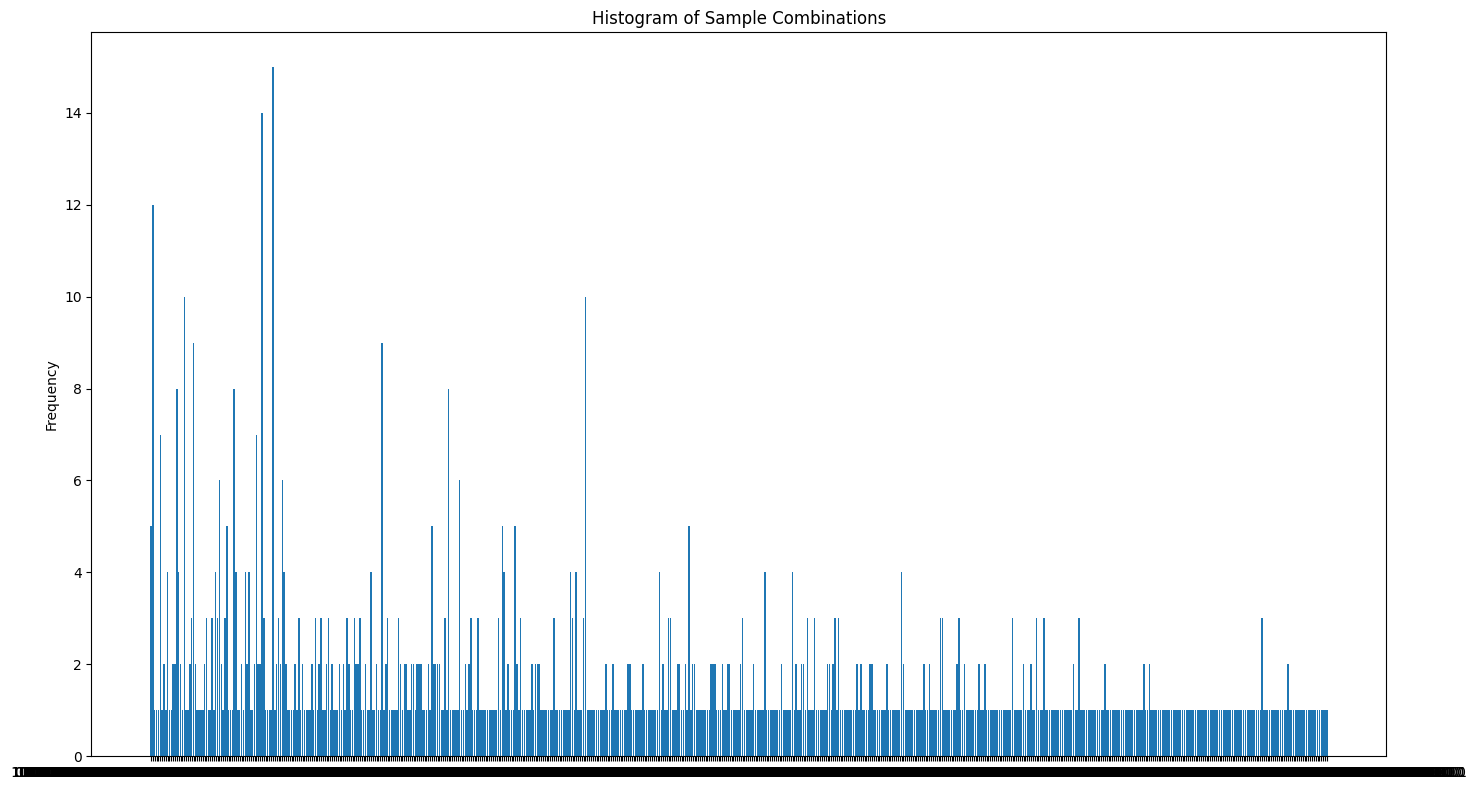

In [257]:
# from collections import Counter
# import matplotlib.pyplot as plt

# samples = []
# tensor_network = tensor_network / tensor_network.norm()
# for _ in range(1000):
#     sample = perfect_sampling_ttn(tensor_network, number_physical_indexes)
#     samples.append(tuple(sample.flatten()))

# # Count the occurrences of each unique sample
# sample_counts = Counter(samples)

# # Create histogram
# labels, values = zip(*sample_counts.items())
# indexes = range(len(labels))

# plt.figure(figsize=(15, 8)) 
# plt.bar(indexes, values, tick_label=["".join(map(str, map(int, label))) for label in labels])
# plt.ylabel('Frequency')
# plt.title('Histogram of Sample Combinations')
# plt.tight_layout()
# plt.show()

In [28]:
import os

sample = perfect_sampling_ttn(tensor_network, number_physical_indexes)
#convert to 8x8 matrix
sample_matrix = sample.reshape(8, 8, bond_dimension)[:, :, 0]
print(sample_matrix)

[[0. 0. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 0. 0. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 1. 0. 1. 1. 0. 1.]
 [0. 1. 1. 1. 1. 1. 0. 1.]
 [1. 0. 1. 0. 0. 0. 0. 0.]]


Since a tensor network is a representation of a quantum state, we are effectively sampling from the quantum state probability distribution.

## MERA - Generative Adversarial Network

### Introduction

Here, we develop a Generative Adversarial Network (GAN) where the generator is based on a tensor network, specifically the Multi-scale Entanglement Renormalization Ansatz (MERA). The goal is to train this GAN to generate data that mimics a given dataset; for now we will use a synthetic dataset.

Conceptually, the tensor network is used to represent a parametrized quantum state, from which we take samples with a perfect sampling algorithm. We want to train out state to generate samples that are similar to the dataset. This is somewhat similar to the idea of the quantum circuit born machines, where the quantum state is given by a quantum circuit and the samples are taken as 'shots'.

### Generator

First we define the tensor network, using definitions from the Quimb library. The number of unbonded indexes in the network is the number of pixels in the image (8x8=64). We can tune the bond dimension to control the complexity of the entanglement structure (corretto??). Increasing the bond dimension has consequences on the computational cost of the training.

In [2]:
# number of sites
n = 2**6
# bond dimension
D = 2
# use single precision
dtype = 'float32'


mera = qtn.MERA.rand_invar(n, D, dtype=dtype)

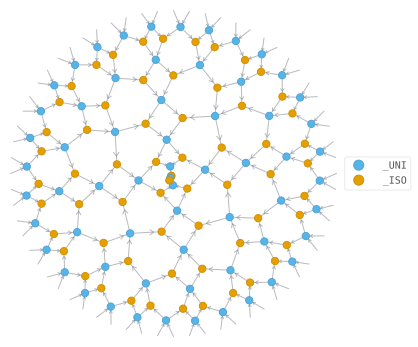

In [13]:
# drawing
from math import cos, sin, pi

fix = {
    f'k{i}': (sin(2 * pi * i / n), cos(2 * pi * i / n))
    for i in range(n)
}

# reduce the 'spring constant' k as well
draw_opts = dict(fix=fix, k=0.01)

mera.draw(color=['_UNI', '_ISO'], **draw_opts)

Define perfect sampling, as mentioned in chapter 1-3. References:

https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.155131 chapter II-F

https://tensornetwork.org/mps/algorithms/sampling/

https://arxiv.org/abs/1201.3974


The standard name for uncontracted indices here is $k_i$, and now all the tensors must have pytorch backend for training.

In [11]:
def perfect_sampling_ttn(ttn,number_indexes):
    s_hat = np.zeros([number_indexes,2])
    probability = np.zeros(number_indexes)

    # cycle 0: the ttn is connected to the conjugate, except for the ph0 index, we obtain a matrix, multiplied by the basis vectors
    # gives me the probability of extracting the first element. We extract the first element
    # cycle 1: the vector extracted in the previous cycle is connected to the ph0 index of the ttn. The procedure repeats identically

    for i in range(number_indexes):
        step_tensor_network = ttn

        for j in range(i): 
            # for each cycle connect a tensor to an index (in sequence from ph0 to ph14) up to the index before 
            # the one I want to sample
            v = qtn.Tensor(data=torch.tensor(s_hat[j], dtype=torch.float32), inds=[f'k{j}'], tags=[f'v{int(s_hat[j][0])}'])
            step_tensor_network = step_tensor_network & v
            step_tensor_network = step_tensor_network / np.sqrt(probability[j])

        # take the complex conjugate of the new network with the same indices as the first one except for the one I want to sample
        step_tensor_network_full = step_tensor_network.H.reindex({f'k{i}':f'k{i}*'}) & step_tensor_network

        # contraction of the network, I get the probability matrix of extracting the new element
        reduced_tensor_network = step_tensor_network_full.contract(all)

        # calculate the probability of extracting the two elements
        v0 = qtn.Tensor(data=torch.tensor([0, 1], dtype=torch.float32), inds=[f'k{i}'])
        v1 = qtn.Tensor(data=torch.tensor([1, 0], dtype=torch.float32), inds=[f'k{i}'])
        
        ps0 = v0 @ reduced_tensor_network @ v0.reindex({f'k{i}':f'k{i}*'})
        ps1 = v1 @ reduced_tensor_network @ v1.reindex({f'k{i}':f'k{i}*'})

        # check if the probability is normalized
        if ps0+ps1<0.999 or ps0+ps1>1.001:
            print("errore al ciclo: ",i)
            print('ps0: ',ps0)
            print('ps1: ',ps1)
        

        #extracting new element
        r = np.random.uniform(0, 1)
        if r < ps0:
            s_hat[i] = v0.data.cpu().numpy()
            probability[i] = ps0
        else:
            s_hat[i] = v1.data.cpu().numpy()
            probability[i] = ps1
    return s_hat


Now we need to convert the tensor network to a pytorch model. (https://quimb.readthedocs.io/en/latest/examples/ex_quimb_within_torch.html)

In [15]:
# parametrize our tensors as isometric/unitary
def norm_fn(mera):
    return mera.isometrize(method="cayley")

In [5]:
class Generator(torch.nn.Module):

    def __init__(self, tn):
        super().__init__()
        # extract the raw arrays and a skeleton of the TN
        params, self.skeleton = qtn.pack(tn)
        # n.b. you might want to do extra processing here to e.g. store each
        # parameter as a reshaped matrix (from left_inds -> right_inds), for
        # some optimizers, and for some torch parametrizations
        self.torch_params = torch.nn.ParameterDict({
            # torch requires strings as keys
            str(i): torch.nn.Parameter(initial)
            for i, initial in params.items()
        })

    def forward(self):
        # convert back to original int key format
        params = {int(i): p for i, p in self.torch_params.items()}
        # reconstruct the TN with the new parameters
        psi = qtn.unpack(params, self.skeleton)
        # isometrize and then return the energy
        return perfect_sampling_ttn(norm_fn(psi), 64)

In [ ]:
# TEST
# mera.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float32))
# fake_sample = Generator(mera).forward()
# print(fake_sample)

### Discriminator

For the discriminator, we will use a basic linear neural network. The input will be the flattened image and the output will be a single value, the probability that the image is real.

In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_size=64):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, data):
        data = data.view(data.size(0), -1)  # Flatten the input tensor
        out = self.model(data)
        return out

### Training loop

The function real_batch_maker is defined to create a synthetic dataset of 8x8 images with a little noise

In [7]:
def real_batch_maker(batch_size, n=8, noise_level=0.1):
    # Define 8x8 matrices for digits 1
    digit_1 = np.array([
        [0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0]
    ], dtype=np.float32)

    matrices = []
    for i in range(batch_size):
        # Add noise to digit 1
        noise = np.random.rand(n, n) < noise_level
        noisy_digit_1 = np.where(noise, 1 - digit_1, digit_1)
        matrices.append(noisy_digit_1.flatten())
    return np.array(matrices).T

The function fake_batch_maker is defined to generate a batch of images from the generator.

In [8]:
def fake_batch_maker(generator, batch_size):
    fake_batch=[]
    for _ in range(batch_size):
        fake_sample = generator.forward()
        # Convert each row ([0,1] or [1,0] states) of fake_sample to a single value: 0 and 1
        fake_column_vector = np.array([0 if np.array_equal(row, [0, 1]) else 1 for row in fake_sample])
        fake_batch.append(fake_column_vector)
    return fake_batch

Notes about training:
- since with equal learning rates the discriminator was too strong, I tried to lower the learning rate of the discriminator
- since the dataset is synthetic, batch size and number are parameters we can set. On my machine th execution is slow, i have just done a few epochs to see if the code works (there is a python script in the repo to avoid using the notebook).

In [ ]:
# setting hyperparameters, since i am using synthetic dataset i am making up the size of the dataset
# for each batch number iteration i will generate a new fake batch
num_epochs = 100
batch_number = 2
batch_size = 5

# initialize models
mera.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float32))
generator = Generator(mera)
discriminator = Discriminator()

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00001)

# Lists to store losses
losses_D = []
losses_G = []

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i in range(batch_number):
        
        # Generate real data
        real_data = torch.tensor(np.array(real_batch_maker(batch_size)), dtype=torch.float32)

        # Generate fake data
        fake_data = torch.tensor(np.array(fake_batch_maker(generator, batch_size)), dtype=torch.float32)

        # Create labels
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # === Train Discriminator ===
        # On real data
        discriminator.train()  # Ensure batchnorm/dropout behaves correctly
        outputs_real = discriminator(real_data.T)
        loss_real = criterion(outputs_real, real_labels)

        # On fake data
        outputs_fake = discriminator(fake_data.detach())
        loss_fake = criterion(outputs_fake, fake_labels)

        # Total loss and optimization for discriminator
        loss_D = loss_real + loss_fake
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # === Train Generator ===
        # Reuse fake data for generator training
        outputs_fake = discriminator(fake_data)
        loss_G = criterion(outputs_fake, real_labels)  # Labels are real for generator training

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    # Store losses
    losses_D.append(loss_D.item())
    losses_G.append(loss_G.item())

    # Logging epoch progress
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(losses_D, label='Discriminator Loss')
plt.plot(losses_G, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Losses During Training')
plt.show()